In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


corrientes = pd.read_csv('corrientes.csv')
potencias = pd.read_csv('potencias.csv')

corrientes['timestamp'] = pd.to_datetime(corrientes['timestamp'])
potencias['timestamp'] = pd.to_datetime(potencias['timestamp'])

# Unir los dataframes en base al ID y timestamp
merged_df = pd.merge(corrientes, potencias, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
merged_df['año'] = merged_df['timestamp'].dt.year
merged_df['mes'] = merged_df['timestamp'].dt.month
merged_df['dia'] = merged_df['timestamp'].dt.day
merged_df['hora'] = merged_df['timestamp'].dt.hour
merged_df['minuto'] = merged_df['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
final_df = merged_df[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(final_df)


         año  mes  dia  hora  minuto  activa  reactiva  aparente     l1  \
0       2021    1    1     0       0  13.584     9.264    16.444  29.16   
1       2021    1    1     0      15  12.492     9.840    15.904  27.30   
2       2021    1    1     0      30  12.468    10.056    16.016  27.12   
3       2021    1    1     0      45  13.032     9.060    15.872  27.18   
4       2021    1    1     1       0  12.540     9.720    15.868  27.12   
...      ...  ...  ...   ...     ...     ...       ...       ...    ...   
117200  2024    5    6     8      45  45.840     3.564    45.980  74.16   
117201  2024    5    6     9       0  52.092     3.084    52.184  77.97   
117202  2024    5    6     9      15  51.996     2.448    52.052  74.55   
117203  2024    5    6     9      30  53.472     2.316    53.524  77.43   
117204  2024    5    6     9      45  59.472     2.280    59.516  82.71   

            l2     l3  
0        25.62  20.85  
1        24.81  20.34  
2        25.56  20.64  
3 

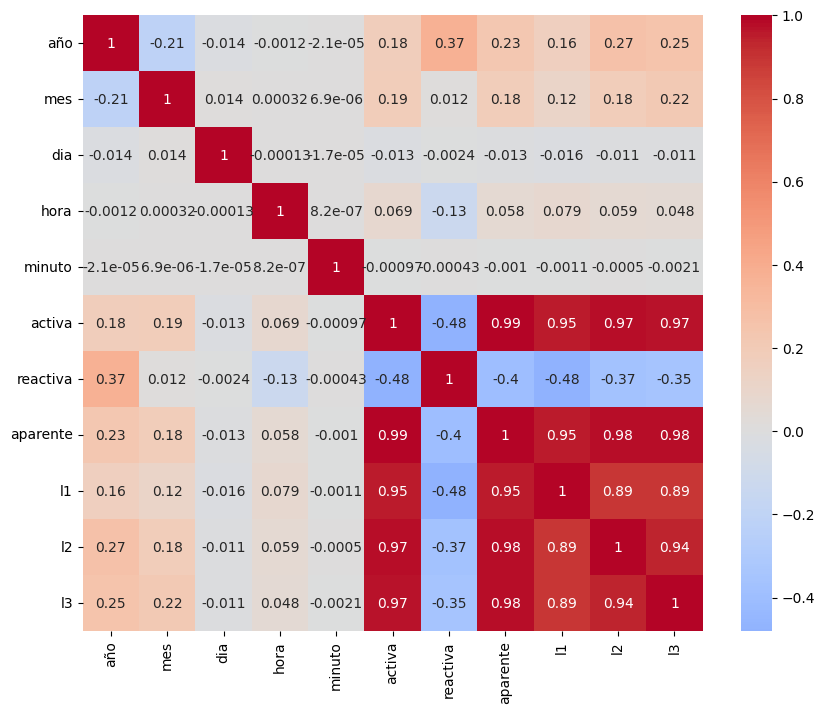

año         0.175960
mes         0.187779
dia        -0.012915
hora        0.068827
minuto     -0.000972
activa      1.000000
reactiva   -0.481186
aparente    0.994164
l1          0.950231
l2          0.972447
l3          0.968129
Name: activa, dtype: float64


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = final_df.corr()

# Generar el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)

# Mostrar el mapa de calor
plt.show()

# Mostrar las correlaciones con la potencia activa
print(corr_matrix['activa'])

<function matplotlib.pyplot.show(close=None, block=None)>

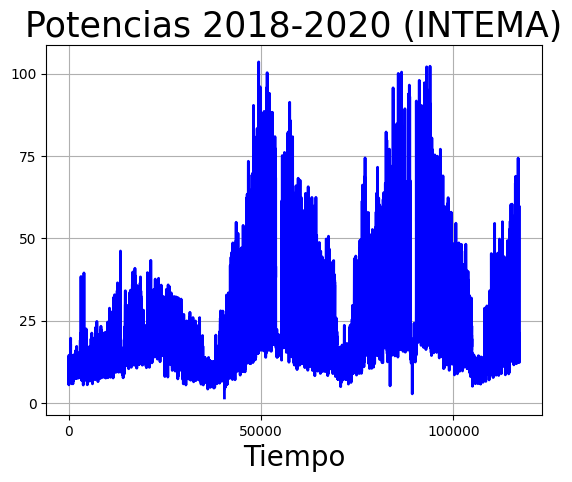

In [3]:
plt.plot(final_df["activa"],'b', linewidth = 2)
plt.rcParams['figure.figsize'] = [20, 20]

plt.grid(True)
plt.title("Potencias 2018-2020 (INTEMA)", fontsize = 25)
plt.xlabel("Tiempo", fontsize = 20)
#plt.ylabel("P [kW]", fontsize = 20)
plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 
plt.show

In [4]:
final_df_copy = final_df.copy()

In [6]:
# Función para crear ventanas deslizantes
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i+ window_size])  # Indexar correctamente para un array unidimensional
    return np.array(X), np.array(y)

# Crear las ventanas deslizantes
mediciones_ventana = 36


activapre, activapost = create_windows(final_df_copy['activa'], mediciones_ventana)
aparentepre, aparentepost = create_windows(final_df_copy['aparente'], mediciones_ventana)
reactivapre, reactivapost = create_windows(final_df_copy['reactiva'], mediciones_ventana)
mespre, mespost = create_windows(final_df_copy['mes'], mediciones_ventana)
diapre, diapost = create_windows(final_df_copy['dia'], mediciones_ventana)
minutopre, minutopost = create_windows(final_df_copy['minuto'], mediciones_ventana)
i1pre, i1post = create_windows(final_df_copy['l1'], mediciones_ventana)
i2pre, i2post = create_windows(final_df_copy['l2'], mediciones_ventana)
i3pre, i3post = create_windows(final_df_copy['l3'], mediciones_ventana)

#print(activapre)
print(activapost)

[ 8.688  8.46   8.22  ... 51.996 53.472 59.472]


In [48]:
print(activapre)

[[13.584 12.492 12.468 ...  9.756 10.176  9.096]
 [12.492 12.468 13.032 ... 10.176  9.096  8.688]
 [12.468 13.032 12.54  ...  9.096  8.688  8.46 ]
 ...
 [19.752 20.136 19.188 ... 44.292 45.84  52.092]
 [20.136 19.188 19.332 ... 45.84  52.092 51.996]
 [19.188 19.332 19.404 ... 52.092 51.996 53.472]]


In [7]:
print(activapre)

[[13.584 12.492 12.468 ...  9.756 10.176  9.096]
 [12.492 12.468 13.032 ... 10.176  9.096  8.688]
 [12.468 13.032 12.54  ...  9.096  8.688  8.46 ]
 ...
 [19.752 20.136 19.188 ... 44.292 45.84  52.092]
 [20.136 19.188 19.332 ... 45.84  52.092 51.996]
 [19.188 19.332 19.404 ... 52.092 51.996 53.472]]


In [50]:
#Armamos los datos con el formato que queremos
X = np.concatenate([activapre, aparentepre, reactivapre, mespre, diapre, minutopre, i1pre, i2pre, i3pre], axis=1)
y = activapost  # Supongamos que queremos predecir la 'activa' post ventana

archivo_salida = 'datos.txt'

nombre_columna = 'X'

# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre las filas del array X
    for fila in X:
        # Convierte cada fila a una cadena de texto con valores separados por comas
        fila_str = ','.join(map(str, fila))
        # Escribe la fila en el archivo y añade una nueva línea
        f.write(f"{fila_str}\n")


In [51]:
X.shape

(117169, 324)

In [55]:
# Proporciones para cada conjunto
train_size = 0.9
val_size = 0.09
test_size = 0.01

# Divide los datos en entrenamiento y temporal (validación + prueba)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=4)

# Calcula la proporción de validación y prueba en el conjunto temporal
val_size_temp = val_size / (val_size + test_size)

# Divide el conjunto temporal en validación y prueba
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_size_temp), random_state=45)

# Verifica las formas de los conjuntos
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (105452, 324)
Forma de X_val: (10545, 324)
Forma de X_test: (1172, 324)
Forma de y_train: (105452,)
Forma de y_val: (10545,)
Forma de y_test: (1172,)


In [56]:

scalerX = StandardScaler()
scalery = StandardScaler()

# Assuming y is a 1D array, reshape it to 2D
y_reshaped = y.reshape(-1, 1)

# Fit and transform X and y_scaled
X_train = scalerX.fit_transform(X_train)
X_val = scalerX.fit_transform(X_val)
X_test = scalerX.fit_transform(X_test)


y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

y_train = scalery.fit_transform(y_train)
y_val = scalery.fit_transform(y_val)
y_test = scalery.fit_transform(y_test)


In [57]:
promedio = np.nanmean(y_train)
# Reemplazar NaN por el promedio calculado
y_train[np.isnan(y_train)] = promedio

promedio = np.nanmean(X_train)
# Reemplazar NaN por el promedio calculado
X_train[np.isnan(X_train)] = promedio

promedio = np.nanmean(X_val)
# Reemplazar NaN por el promedio calculado
X_val[np.isnan(X_val)] = promedio

promedio = np.nanmean(y_val)
# Reemplazar NaN por el promedio calculado
y_val[np.isnan(y_val)] = promedio

promedio = np.nanmean(X_test)
# Reemplazar NaN por el promedio calculado
X_test[np.isnan(X_test)] = promedio

promedio = np.nanmean(y_test)
# Reemplazar NaN por el promedio calculado
y_test[np.isnan(y_test)] = promedio


In [58]:
copia_datos = X
copia_datos
copia_datos2 = copia_datos
print(copia_datos)

[[13.584 12.492 12.468 ... 17.61  17.22  16.32 ]
 [12.492 12.468 13.032 ... 17.22  16.32  15.48 ]
 [12.468 13.032 12.54  ... 16.32  15.48  14.85 ]
 ...
 [19.752 20.136 19.188 ... 59.22  62.1   80.79 ]
 [20.136 19.188 19.332 ... 62.1   80.79  73.89 ]
 [19.188 19.332 19.404 ... 80.79  73.89  71.88 ]]


In [59]:
datos_escalados = scalerX.fit_transform(copia_datos2)
print(datos_escalados)

[[-0.55766643 -0.63950848 -0.64131261 ... -0.87452083 -0.89581917
  -0.94495479]
 [-0.639504   -0.64130711 -0.59904473 ... -0.89580848 -0.94494366
  -0.99080362]
 [-0.64130263 -0.5990393  -0.63591671 ... -0.94493383 -0.99079319
  -1.02519025]
 ...
 [-0.09541903 -0.06664475 -0.1376953  ...  1.39670775  1.55385569
   2.57394319]
 [-0.06664099 -0.13769064 -0.1269035  ...  1.55390886  2.57400772
   2.19732777]
 [-0.13768679 -0.12689886 -0.1215076  ...  2.57407858  2.19738658
   2.08761806]]


In [60]:
datos_desescalados = scalerX.inverse_transform(datos_escalados)
print(datos_desescalados)

[[13.584 12.492 12.468 ... 17.61  17.22  16.32 ]
 [12.492 12.468 13.032 ... 17.22  16.32  15.48 ]
 [12.468 13.032 12.54  ... 16.32  15.48  14.85 ]
 ...
 [19.752 20.136 19.188 ... 59.22  62.1   80.79 ]
 [20.136 19.188 19.332 ... 62.1   80.79  73.89 ]
 [19.188 19.332 19.404 ... 80.79  73.89  71.88 ]]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 400)               130000    
                                                                 
 dense_15 (Dense)            (None, 300)               120300    
                                                                 
 dense_16 (Dense)            (None, 100)               30100     
                                                                 
 dense_17 (Dense)            (None, 30)                3030      
                                                                 
 dense_18 (Dense)            (None, 1)                 31        
                                                                 
Total params: 283461 (1.08 MB)
Trainable params: 283461 (1.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3296/32

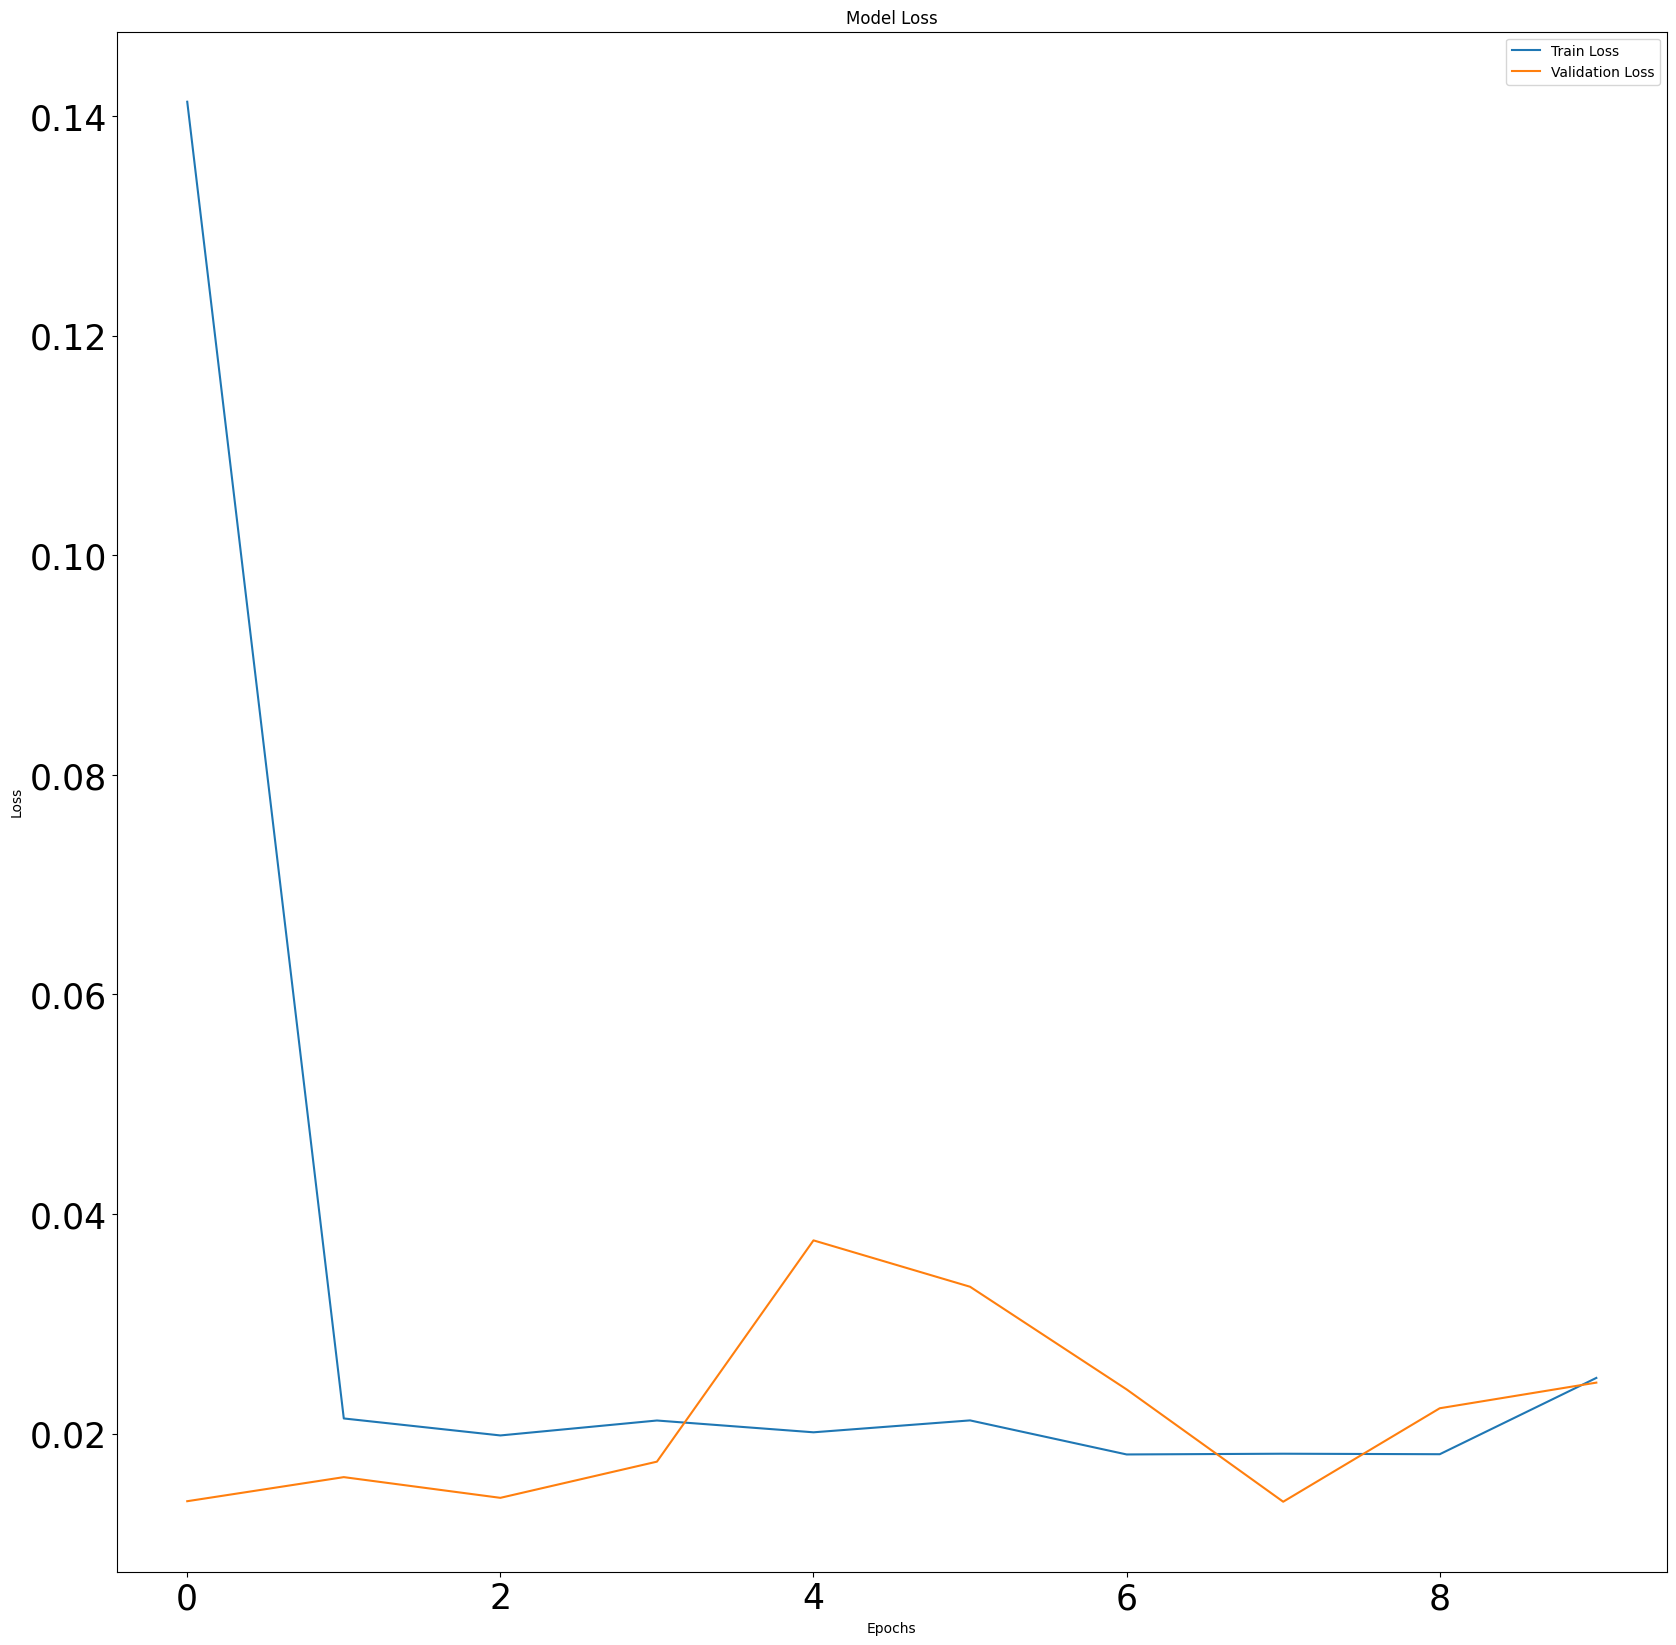

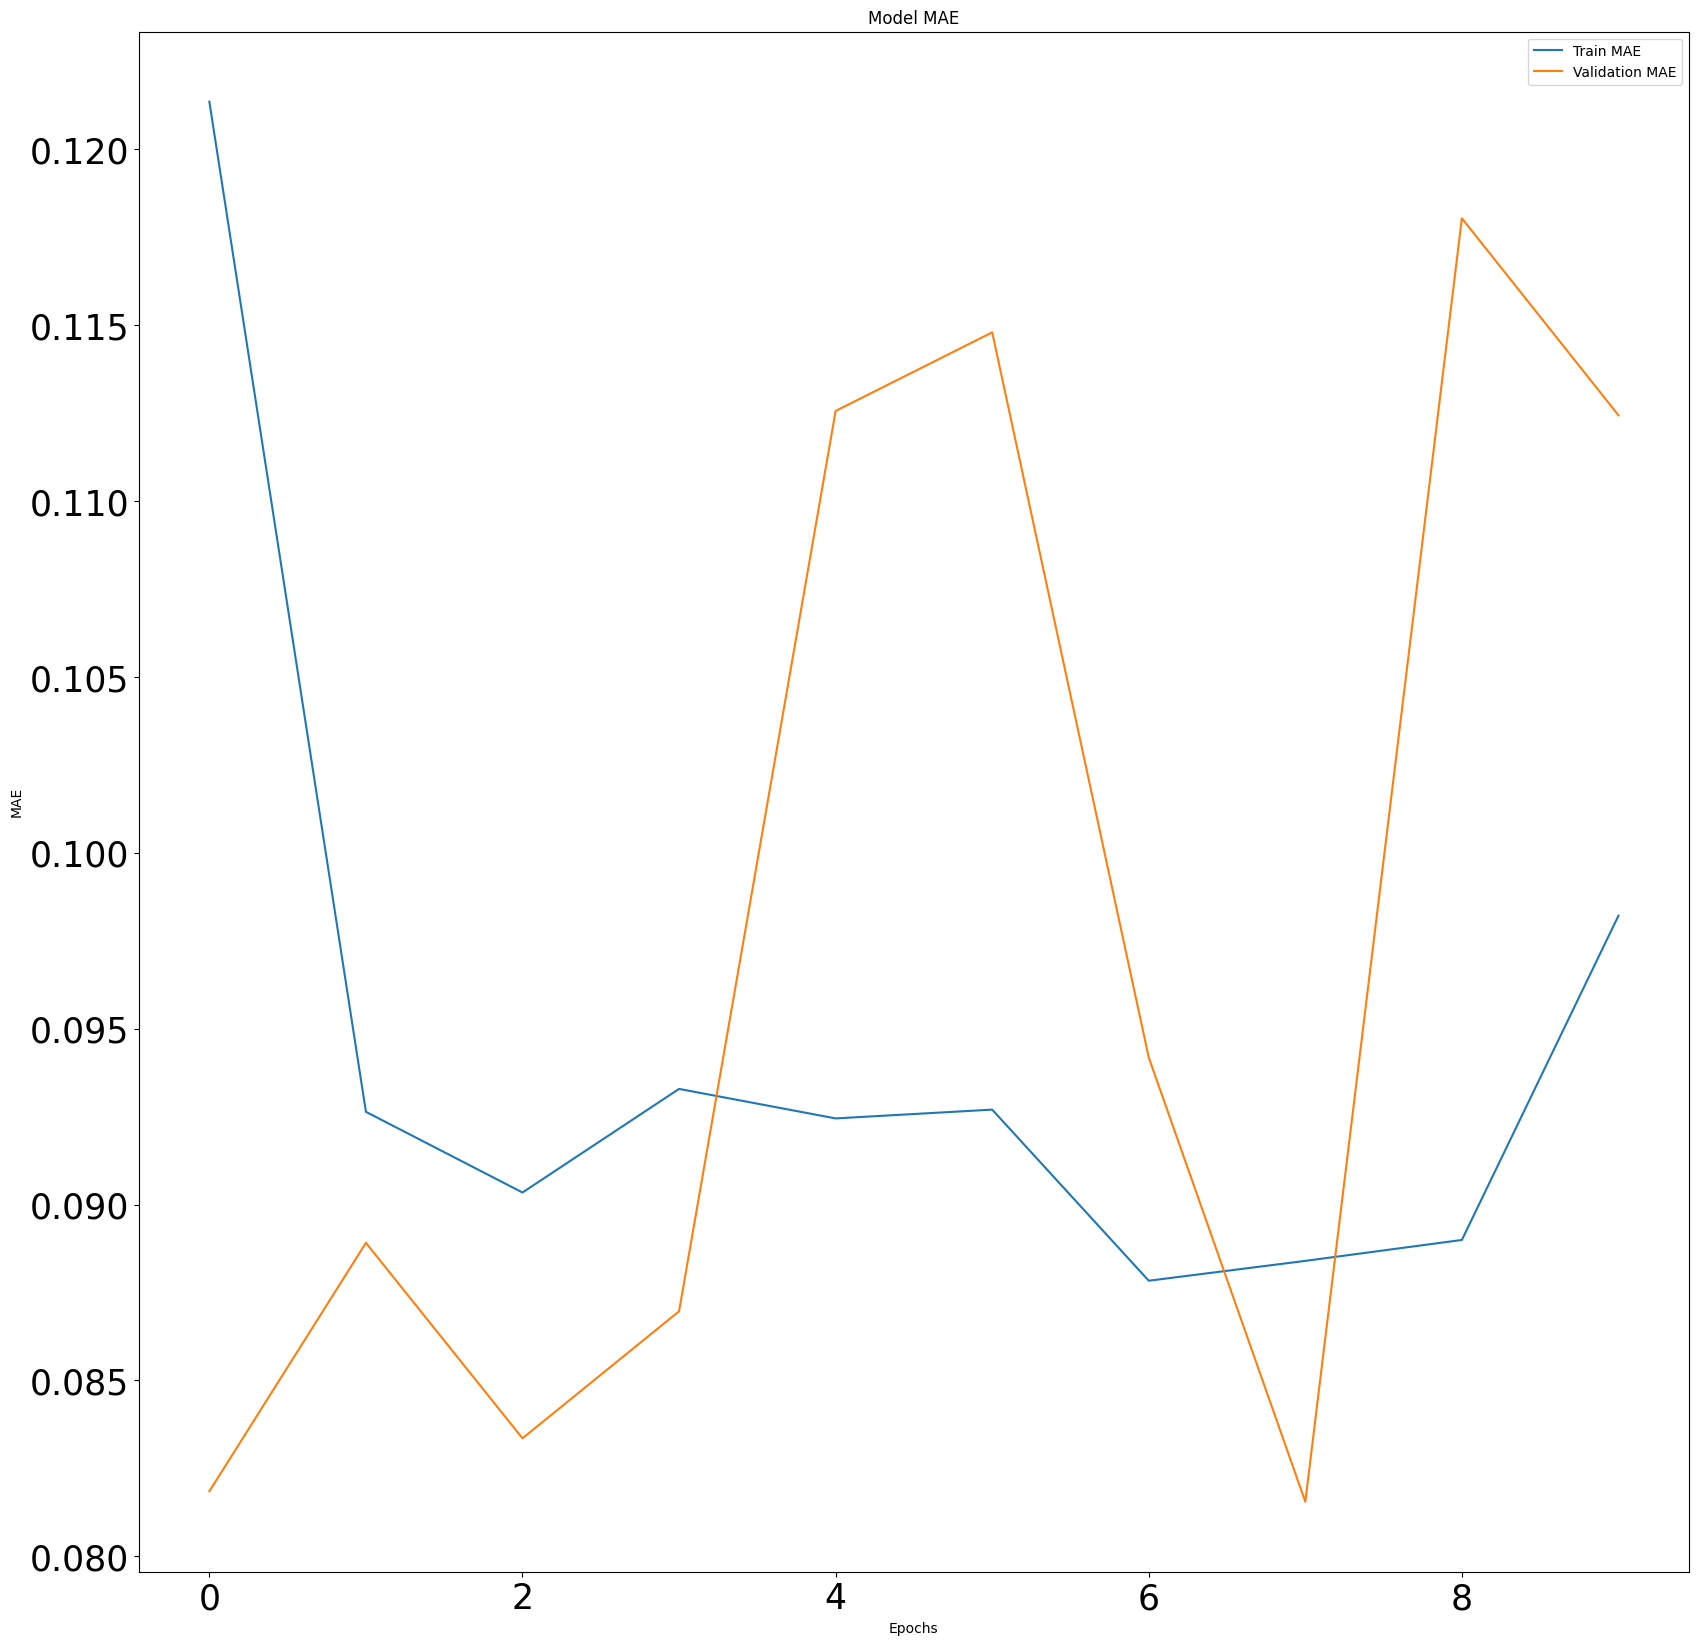

In [63]:
model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(300, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='linear')) # Suponiendo que estás prediciendo un valor continuo

# Definir el optimizador con el learning rate deseado
optimizer = Adam(learning_rate=0.01)

# Compilar el modelo especificando el optimizador y otras configuraciones
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])

model.summary()


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#history = model.fit(X_train, y_train, epochs=2, validation_data=(X_val, y_val), callbacks=[early_stopping],  verbose=1)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32, verbose=1)



# Gráfica de la pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.axvline(x=len(history.history['loss']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Gráfica del MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
#plt.axvline(x=len(history.history['mae']) - early_stopping.patience, color='r', linestyle='--', label='Early Stopping')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [64]:
print(y_test)

[[ 0.69973189]
 [ 2.54096499]
 [ 2.69883835]
 ...
 [ 3.63206608]
 [-0.5212177 ]
 [-0.21854925]]


In [65]:
y_test = scalery.inverse_transform(y_test)


1/1 [==============================] - 0s 70ms/step
[[-0.5488279]]
[[13.709327]]
en test esa pos tenia
[14.076]


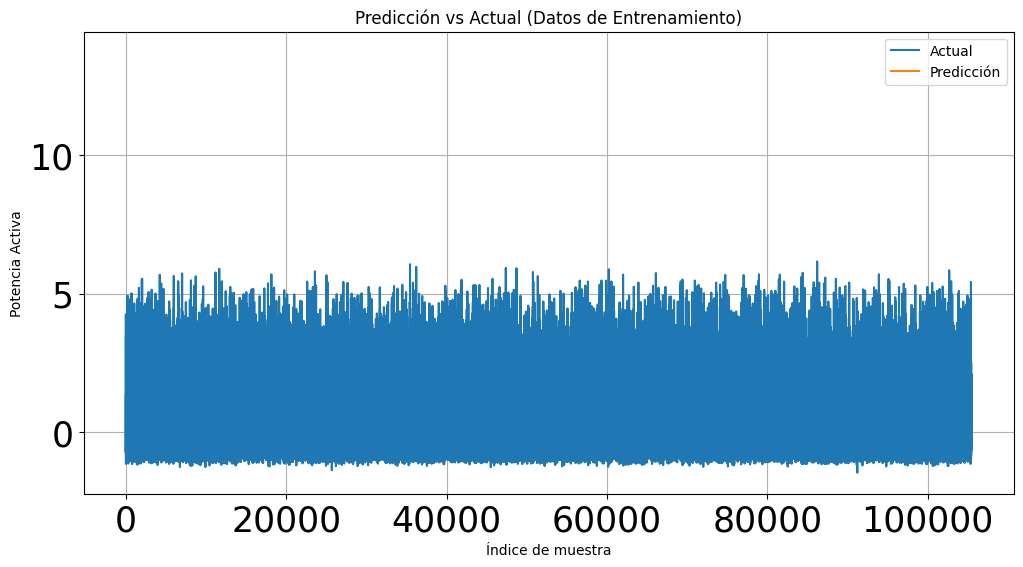

In [66]:
y_test_pred = model.predict(X_test[156,:].reshape(1, -1))
print(y_test_pred)

y_test_pred = scalery.inverse_transform(y_test_pred)
print(y_test_pred)

#a = scalery.inverse_transform([-0.07620964])
print("en test esa pos tenia")
print(y_test[156])


plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_test_pred, label='Predicción')
plt.xlabel('Índice de muestra')
plt.ylabel('Potencia Activa')
plt.title('Predicción vs Actual (Datos de Entrenamiento)')
plt.legend()
plt.grid(True)
plt.show()

In [67]:
y_test = y_test.reshape(-1, 1)


In [68]:
y_test_pred = y_test_pred.reshape(-1, 1)


print(y_test_pred.shape)
print("este es y test", y_test.shape)

(1, 1)
este es y test (1172, 1)


In [69]:
import numpy as np 
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que model es tu modelo ya entrenado y X_test, y_test son tus datos de prueba
# Hacemos predicciones
y_test_pred = model.predict(X_test)




has_nan = np.isnan(y_test_pred).any()
print("¿Hay NaN en los datos y_test_pred?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test_pred))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test_pred[np.isnan(y_test_pred)] = promedio

y_test_pred = scalery.inverse_transform(y_test_pred)





has_nan = np.isnan(y_test).any()
print("¿Hay NaN en los datos y_Test?", has_nan)
nan_positions = np.argwhere(np.isnan(y_test))
print("Posiciones de NaN en los datos X:")
print(nan_positions)

y_test[np.isnan(y_test)] = promedio


# Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_test_pred)



# Calculamos otras métricas de error
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(y_test - y_test_pred) <= margin_of_error)
total_predictions = len(y_test)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')



37/37 [==============================] - 0s 1ms/step
¿Hay NaN en los datos y_test_pred? False
Posiciones de NaN en los datos X:
[]
¿Hay NaN en los datos y_Test? False
Posiciones de NaN en los datos X:
[]
MSE: 4.339555734602851
MAE: 1.4406896570355412
RMSE: 2.0831600357636595
R²: 0.9737017364138024
Número de predicciones dentro del margen de error: 1113
Precisión dentro del margen de error: 94.97%


In [70]:
print(y_test)

[[29.748]
 [53.4  ]
 [55.428]
 ...
 [67.416]
 [14.064]
 [17.952]]


In [71]:
archivo_salida = "datos_estimados.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test_pred:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

In [72]:
archivo_salida = "datos_en_y_test.txt"
# Abre el archivo de texto para escritura
with open(archivo_salida, 'w') as f:
    # Itera sobre los valores de y_train
    for x_test in y_test:
        # Escribe el valor de y_train en el archivo y añade una nueva línea
        f.write(f"{x_test}\n")

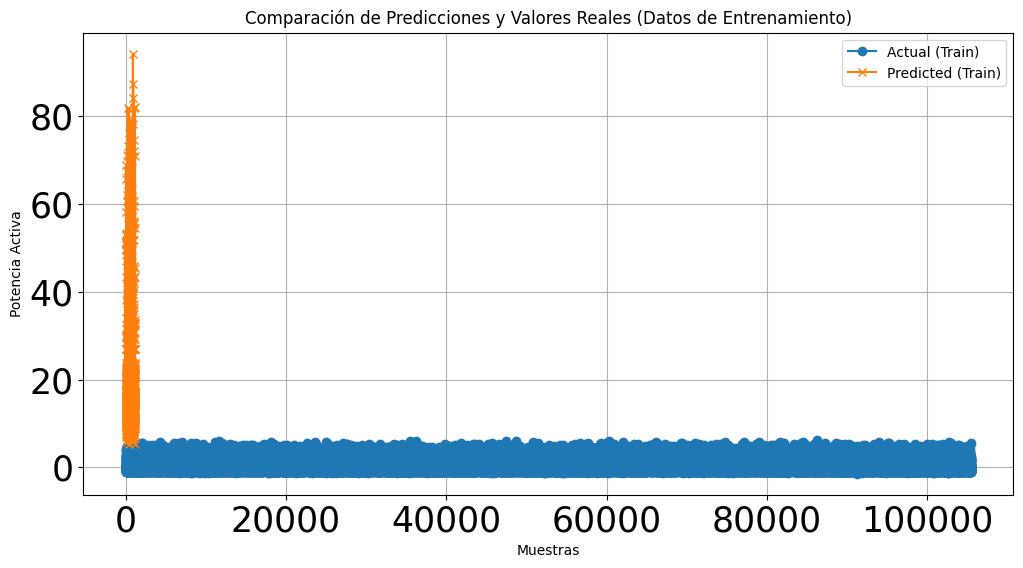

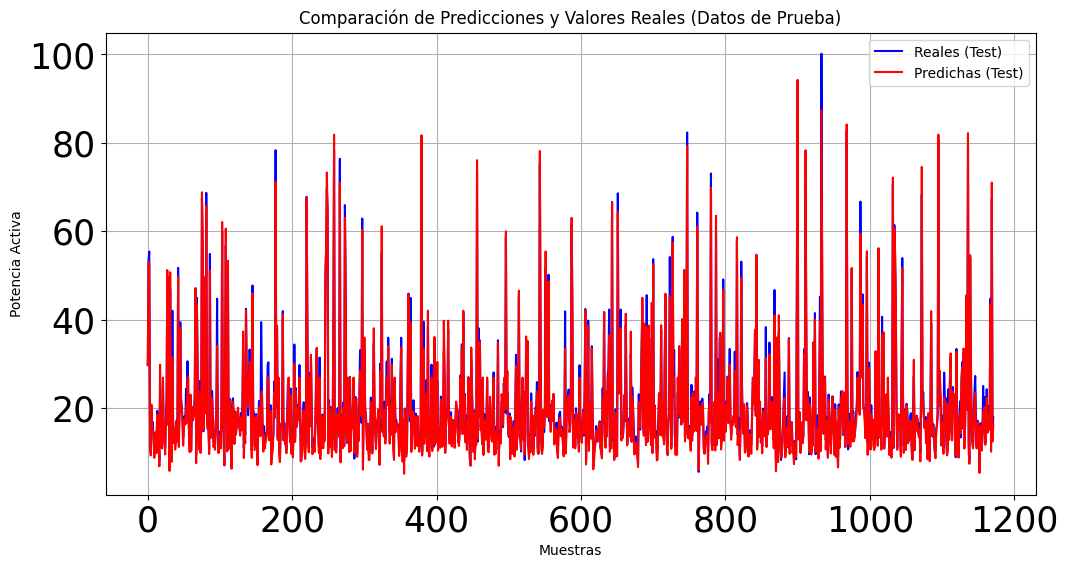

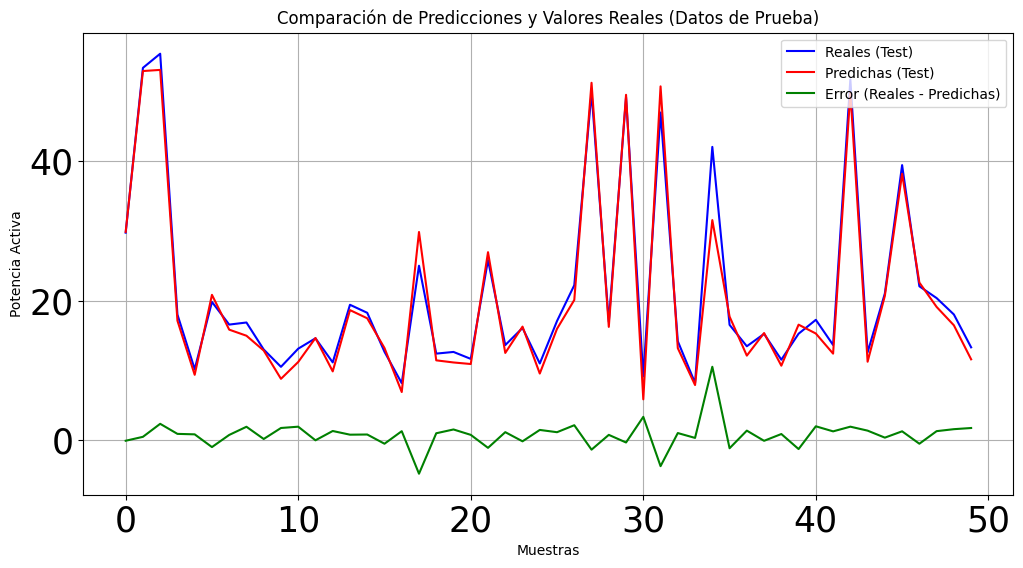

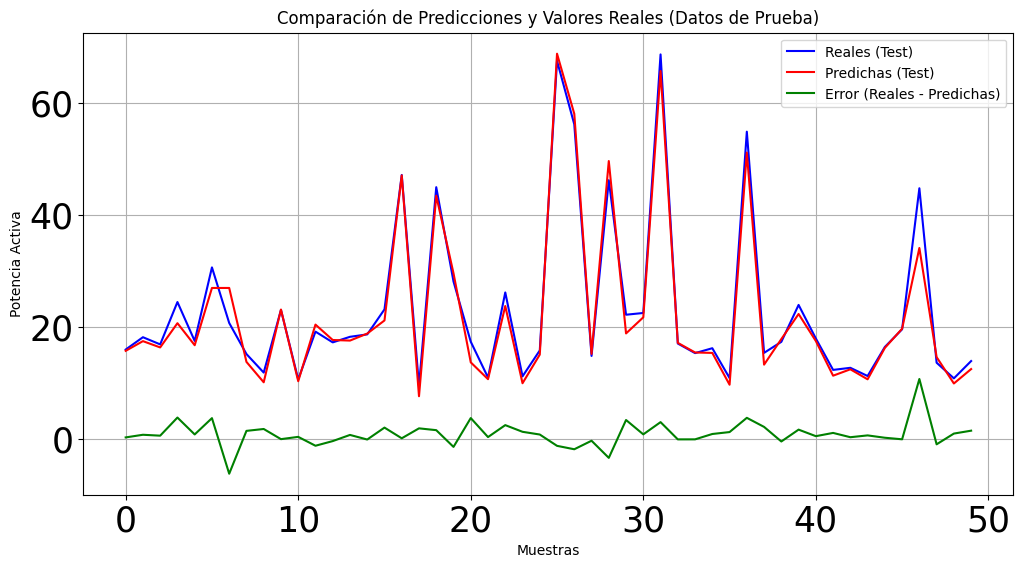

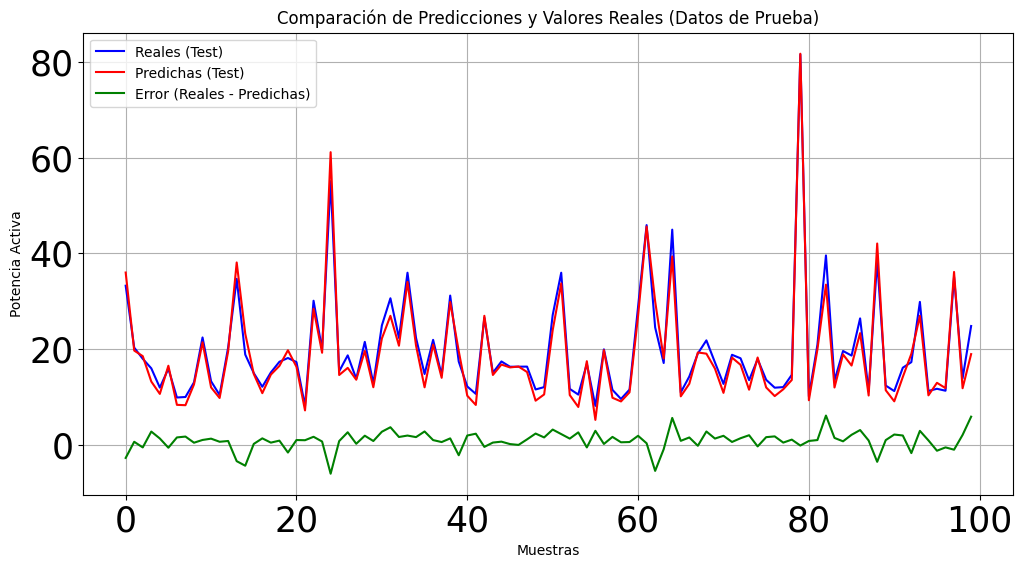

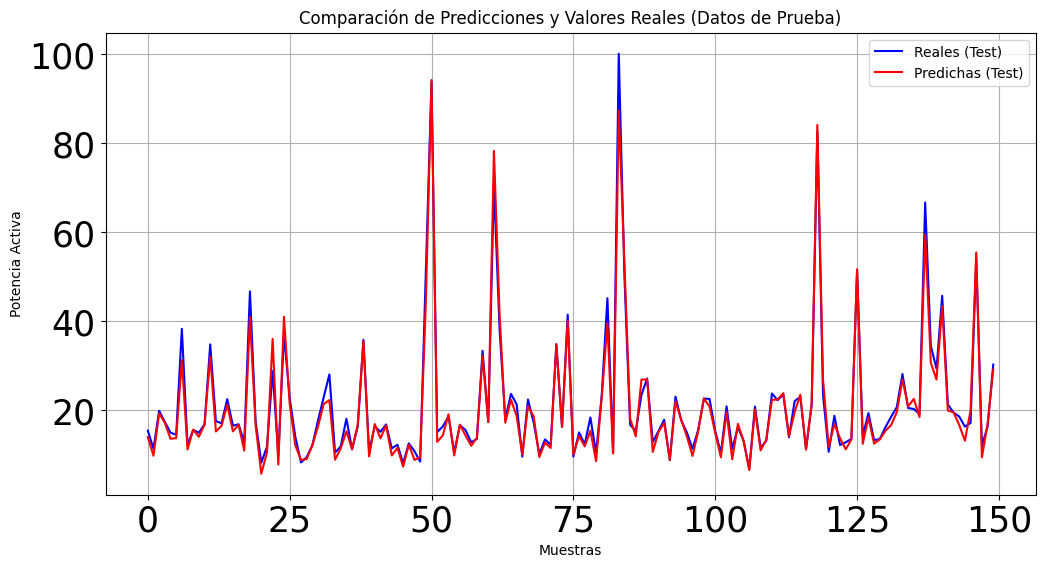

[[-0.10909763]
 [ 0.4551033 ]
 [ 2.32186749]
 ...
 [-3.60887946]
 [ 1.58400237]
 [ 1.68437038]]


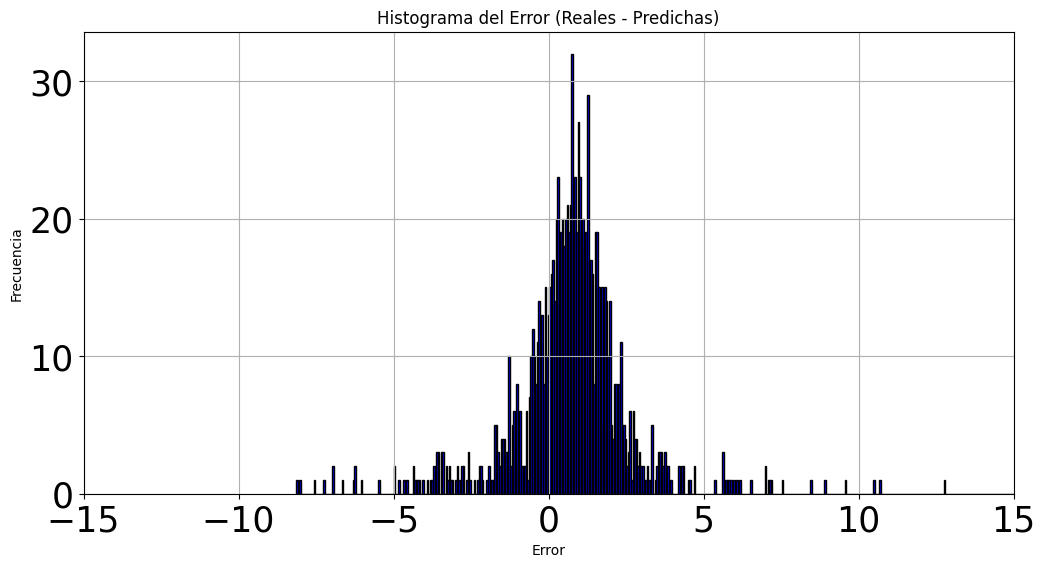

In [73]:

# Plot de datos de entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual (Train)', marker='o')
plt.plot(y_test_pred, label='Predicted (Train)', marker='x')
plt.title('Comparación de Predicciones y Valores Reales (Datos de Entrenamiento)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')
plt.legend()
plt.grid(True)
plt.show()

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los datos reales y predichos como líneas
plt.plot(y_test, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred, label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()



# Calculamos el error (diferencia entre los valores reales y predichos)
error = y_test[:50] - y_test_pred[:50]

# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 50 datos reales y predichos como líneas
plt.plot(y_test[:50], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[:50], label='Predichas (Test)', linestyle='-', color='red')

# Ploteamos el error como línea
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()






# Plot de datos de prueba
plt.figure(figsize=(12, 6))

error = y_test[50:100] - y_test_pred[50:100]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[50:100], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[50:100], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = y_test[300:400] - y_test_pred[300:400]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[300:400], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[300:400], label='Predichas (Test)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()





# Plot de datos de prueba
plt.figure(figsize=(12, 6))

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(y_test[850:1000], label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_pred[850:1000], label='Predichas (Test)', linestyle='-', color='red')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


error = y_test - y_test_pred
print((error))


# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black', color='blue')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

In [74]:
std_deviation = np.std(error)

print(f"Desviación estándar del error: {std_deviation:.2f}")

Desviación estándar del error: 1.96


In [75]:
min_error = np.min(error)
max_error = np.max(error)


# Encontrar los índices de los valores que tienen un valor absoluto mayor que 1
indices = np.where(np.abs(error) > 0.7)
# Contar cuántos valores cumplen la condición
cont = len(indices[0])

with open("resultados.txt", "w") as file:
    file.write(f"Valor minimo del error: {min_error}\n")
    file.write(f"Valor maximo del error: {max_error}\n")
    file.write(f"Cantidad de valores con modulo mayor que el elegido: {cont}\n")

    file.write("Posiciones y valores:\n")
    for i in range(cont):
        row = indices[0][i]
        col = indices[1][i]
        file.write(f"indice: ({row}, {col}), Valor: {error[row, col]}\n")

In [76]:
# Leer los CSV a partir de la fila 117207 (recordar que skiprows es 0-based)

# Leer los encabezados del archivo
encabezados_corrientes = pd.read_csv('corrientes.csv', nrows=0).columns
encabezados_potencias = pd.read_csv('potencias.csv', nrows=0).columns

#corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
#potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
corrientes_nuevas = pd.read_csv('corrientes_nuevo.csv', skiprows=117206, header=None, names=encabezados_corrientes)
#print(corrientes_nuevas)
potencias_nuevas = pd.read_csv('potencias_nuevo.csv', skiprows=117206, header=None, names=encabezados_potencias)
print(potencias_nuevas)

# Convertir la columna 'timestamp' a datetime
corrientes_nuevas['timestamp'] = pd.to_datetime(corrientes_nuevas['timestamp'])
potencias_nuevas['timestamp'] = pd.to_datetime(potencias_nuevas['timestamp'])

# Unir los dataframes en base al ID y timestamp
df_unido = pd.merge(corrientes_nuevas, potencias_nuevas, on=['id', 'timestamp'])

# Separar la columna de timestamp en año, mes, día, hora, minuto
df_unido['año'] = df_unido['timestamp'].dt.year
df_unido['mes'] = df_unido['timestamp'].dt.month
df_unido['dia'] = df_unido['timestamp'].dt.day
df_unido['hora'] = df_unido['timestamp'].dt.hour
df_unido['minuto'] = df_unido['timestamp'].dt.minute

# Seleccionar y reorganizar las columnas en el formato deseado
df_nuevo = df_unido[['año', 'mes', 'dia', 'hora', 'minuto', 'activa', 'reactiva', 'aparente', 'l1', 'l2', 'l3']]

# Mostrar el dataframe resultante
print(df_nuevo)

        id  activa  reactiva  aparente            timestamp
0     2103  62.232     1.680    62.256  2024-05-06 10:00:00
1     2103  60.936     2.052    60.972  2024-05-06 10:15:00
2     2103  65.832     2.088    65.864  2024-05-06 10:30:00
3     2103  65.952     2.724    66.008  2024-05-06 10:45:00
4     2103  71.136     2.496    71.180  2024-05-06 11:00:00
...    ...     ...       ...       ...                  ...
4144  2103  72.084     1.476    72.100  2024-06-18 14:00:00
4145  2103  73.680     2.880    73.736  2024-06-18 14:15:00
4146  2103  66.384     1.992    66.412  2024-06-18 14:30:00
4147  2103  59.928     1.956    59.960  2024-06-18 14:45:00
4148  2103  58.584     2.520    58.640  2024-06-18 15:00:00

[4149 rows x 5 columns]
       año  mes  dia  hora  minuto  activa  reactiva  aparente      l1  \
0     2024    5    6    10       0  62.232     1.680    62.256   78.33   
1     2024    5    6    10      15  60.936     2.052    60.972   78.42   
2     2024    5    6    10      3

In [77]:
activaprenueva, activapostnueva = create_windows(df_nuevo['activa'], mediciones_ventana)
aparenteprenueva, aparentepostnueva = create_windows(df_nuevo['aparente'], mediciones_ventana)
reactivaprenueva, reactivapostnueva = create_windows(df_nuevo['reactiva'], mediciones_ventana)
mesprenueva, mespostnueva = create_windows(df_nuevo['mes'], mediciones_ventana)
diaprenueva, diapostnueva = create_windows(df_nuevo['dia'], mediciones_ventana)
minutoprenueva, minutopostnueva = create_windows(df_nuevo['minuto'], mediciones_ventana)
i1prenueva, i1postnueva = create_windows(df_nuevo['l1'], mediciones_ventana)
i2prenueva, i2postnueva = create_windows(df_nuevo['l2'], mediciones_ventana)
i3prenueva, i3postnueva = create_windows(df_nuevo['l3'], mediciones_ventana)

In [78]:
activaprenueva

array([[62.232, 60.936, 65.832, ..., 33.084, 32.4  , 29.388],
       [60.936, 65.832, 65.952, ..., 32.4  , 29.388, 27.84 ],
       [65.832, 65.952, 71.136, ..., 29.388, 27.84 , 27.012],
       ...,
       [18.84 , 21.48 , 20.7  , ..., 68.916, 72.084, 73.68 ],
       [21.48 , 20.7  , 19.92 , ..., 72.084, 73.68 , 66.384],
       [20.7  , 19.92 , 21.012, ..., 73.68 , 66.384, 59.928]])

In [31]:
activapostnueva

array([27.84 , 27.012, 26.208, ..., 66.384, 59.928, 58.584])

In [79]:
Xnuevo = np.concatenate([activaprenueva, aparenteprenueva, reactivaprenueva, mesprenueva, diaprenueva, minutoprenueva, i1prenueva, i2prenueva, i3prenueva], axis=1)
ynuevo = activapostnueva  # Supongamos que queremos predecir la 'activa' post ventana
ynuevo
ynuevo.shape

(4113,)

In [33]:
Xnuevo = scalerX.fit_transform(Xnuevo)



In [34]:
Xnuevo

array([[ 1.79276798,  1.72082375,  1.99836287, ...,  0.49471785,
         0.53431368,  0.32107443],
       [ 1.71964452,  1.99716412,  2.00513812, ...,  0.53501628,
         0.32142437,  0.14965999],
       [ 1.99588873,  2.00393716,  2.29782914, ...,  0.32201032,
         0.14996217,  0.04612107],
       ...,
       [-0.65551405, -0.50615452, -0.54981055, ...,  2.14004494,
         2.39277982,  2.45052494],
       [-0.50655884, -0.55017934, -0.5938497 , ...,  2.39450071,
         2.45146822,  2.17787244],
       [-0.55056833, -0.59420415, -0.53219488, ...,  2.45322127,
         2.17873976,  1.60495707]])

In [35]:
#y_test_prednuevo = model.predict(Xnuevo[0,:].reshape(1, -1))
y_test_prednuevo = model.predict(Xnuevo)
y_test_prednuevo = scalery.inverse_transform(y_test_prednuevo)
#y_test_prednuevo = y_test_prednuevo + 20


129/129 [==============================] - 0s 920us/step


In [36]:
ynuevo

array([27.84 , 27.012, 26.208, ..., 66.384, 59.928, 58.584])

In [37]:
y_test_prednuevo

array([[20.149925],
       [20.001743],
       [17.818447],
       ...,
       [52.115696],
       [48.11577 ],
       [44.318653]], dtype=float32)

In [38]:
ynuevo = ynuevo.reshape(-1, 1)


In [39]:
mse = mean_squared_error(ynuevo, y_test_prednuevo)



# Calculamos otras métricas de error
mae = mean_absolute_error(ynuevo, y_test_prednuevo)
rmse = np.sqrt(mse)
r2 = r2_score(ynuevo, y_test_prednuevo)

# Imprimimos las métricas de error
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'R²: {r2}')

# Definimos un margen de error aceptable (por ejemplo, 10 unidades) 12.45
margin_of_error = 4

# Calculamos cuántas predicciones están dentro del margen de error
within_margin = np.sum(np.abs(ynuevo - y_test_prednuevo) <= margin_of_error)
total_predictions = len(ynuevo)
accuracy_within_margin = within_margin / total_predictions

# Imprimimos la precisión dentro del margen de error
print(f'Número de predicciones dentro del margen de error: {within_margin}')
print(f'Precisión dentro del margen de error: {accuracy_within_margin:.2%}')

MSE: 105.45984126681692
MAE: 9.290478771900682
RMSE: 10.26936420947358
R²: 0.6639910350626792
Número de predicciones dentro del margen de error: 10
Precisión dentro del margen de error: 0.24%


In [40]:
ynuevo.shape

(4113, 1)

In [41]:
ynuevo.shape

(4113, 1)

In [42]:
ynuevo
ynuevo.shape
y_test_prednuevo.shape

(4113, 1)

In [43]:
error = ynuevo[4045:4145] - y_test_prednuevo[4045:4145]
print(error)
error.shape

[[ 7.27511552]
 [ 7.08785098]
 [ 8.09580843]
 [ 8.88829333]
 [ 7.49389665]
 [ 6.79437246]
 [ 8.7189187 ]
 [ 5.95693314]
 [ 7.36006424]
 [ 6.55963965]
 [ 7.68229575]
 [ 7.6268905 ]
 [ 8.8152187 ]
 [ 7.33441331]
 [ 7.96904591]
 [ 7.64699966]
 [ 6.95782494]
 [ 7.95743542]
 [ 7.91535966]
 [ 7.60762891]
 [ 7.05877223]
 [ 9.37251798]
 [ 7.9431127 ]
 [ 7.13301323]
 [ 7.86747991]
 [ 6.82253479]
 [ 6.36056436]
 [ 7.62115952]
 [ 7.26091556]
 [ 8.65223583]
 [10.3969178 ]
 [ 7.95784683]
 [ 6.77237885]
 [ 8.57258121]
 [ 9.52429653]
 [ 5.24649857]
 [ 7.04826818]
 [ 9.6845267 ]
 [11.44666624]
 [19.19116008]
 [19.35487492]
 [13.02761615]
 [ 9.28278171]
 [13.61977603]
 [11.64449704]
 [15.31619748]
 [22.20035367]
 [12.25724466]
 [15.81680695]
 [18.22621078]
 [18.32491415]
 [17.13923224]
 [17.13974069]
 [19.36675116]
 [22.0209339 ]
 [14.88004962]
 [19.39253271]
 [17.10574661]
 [16.57359995]
 [12.18274838]
 [13.3353237 ]
 [15.17178265]
 [22.9201008 ]
 [20.676659  ]
 [21.52231186]
 [14.26830405]
 [11.81223

(68, 1)

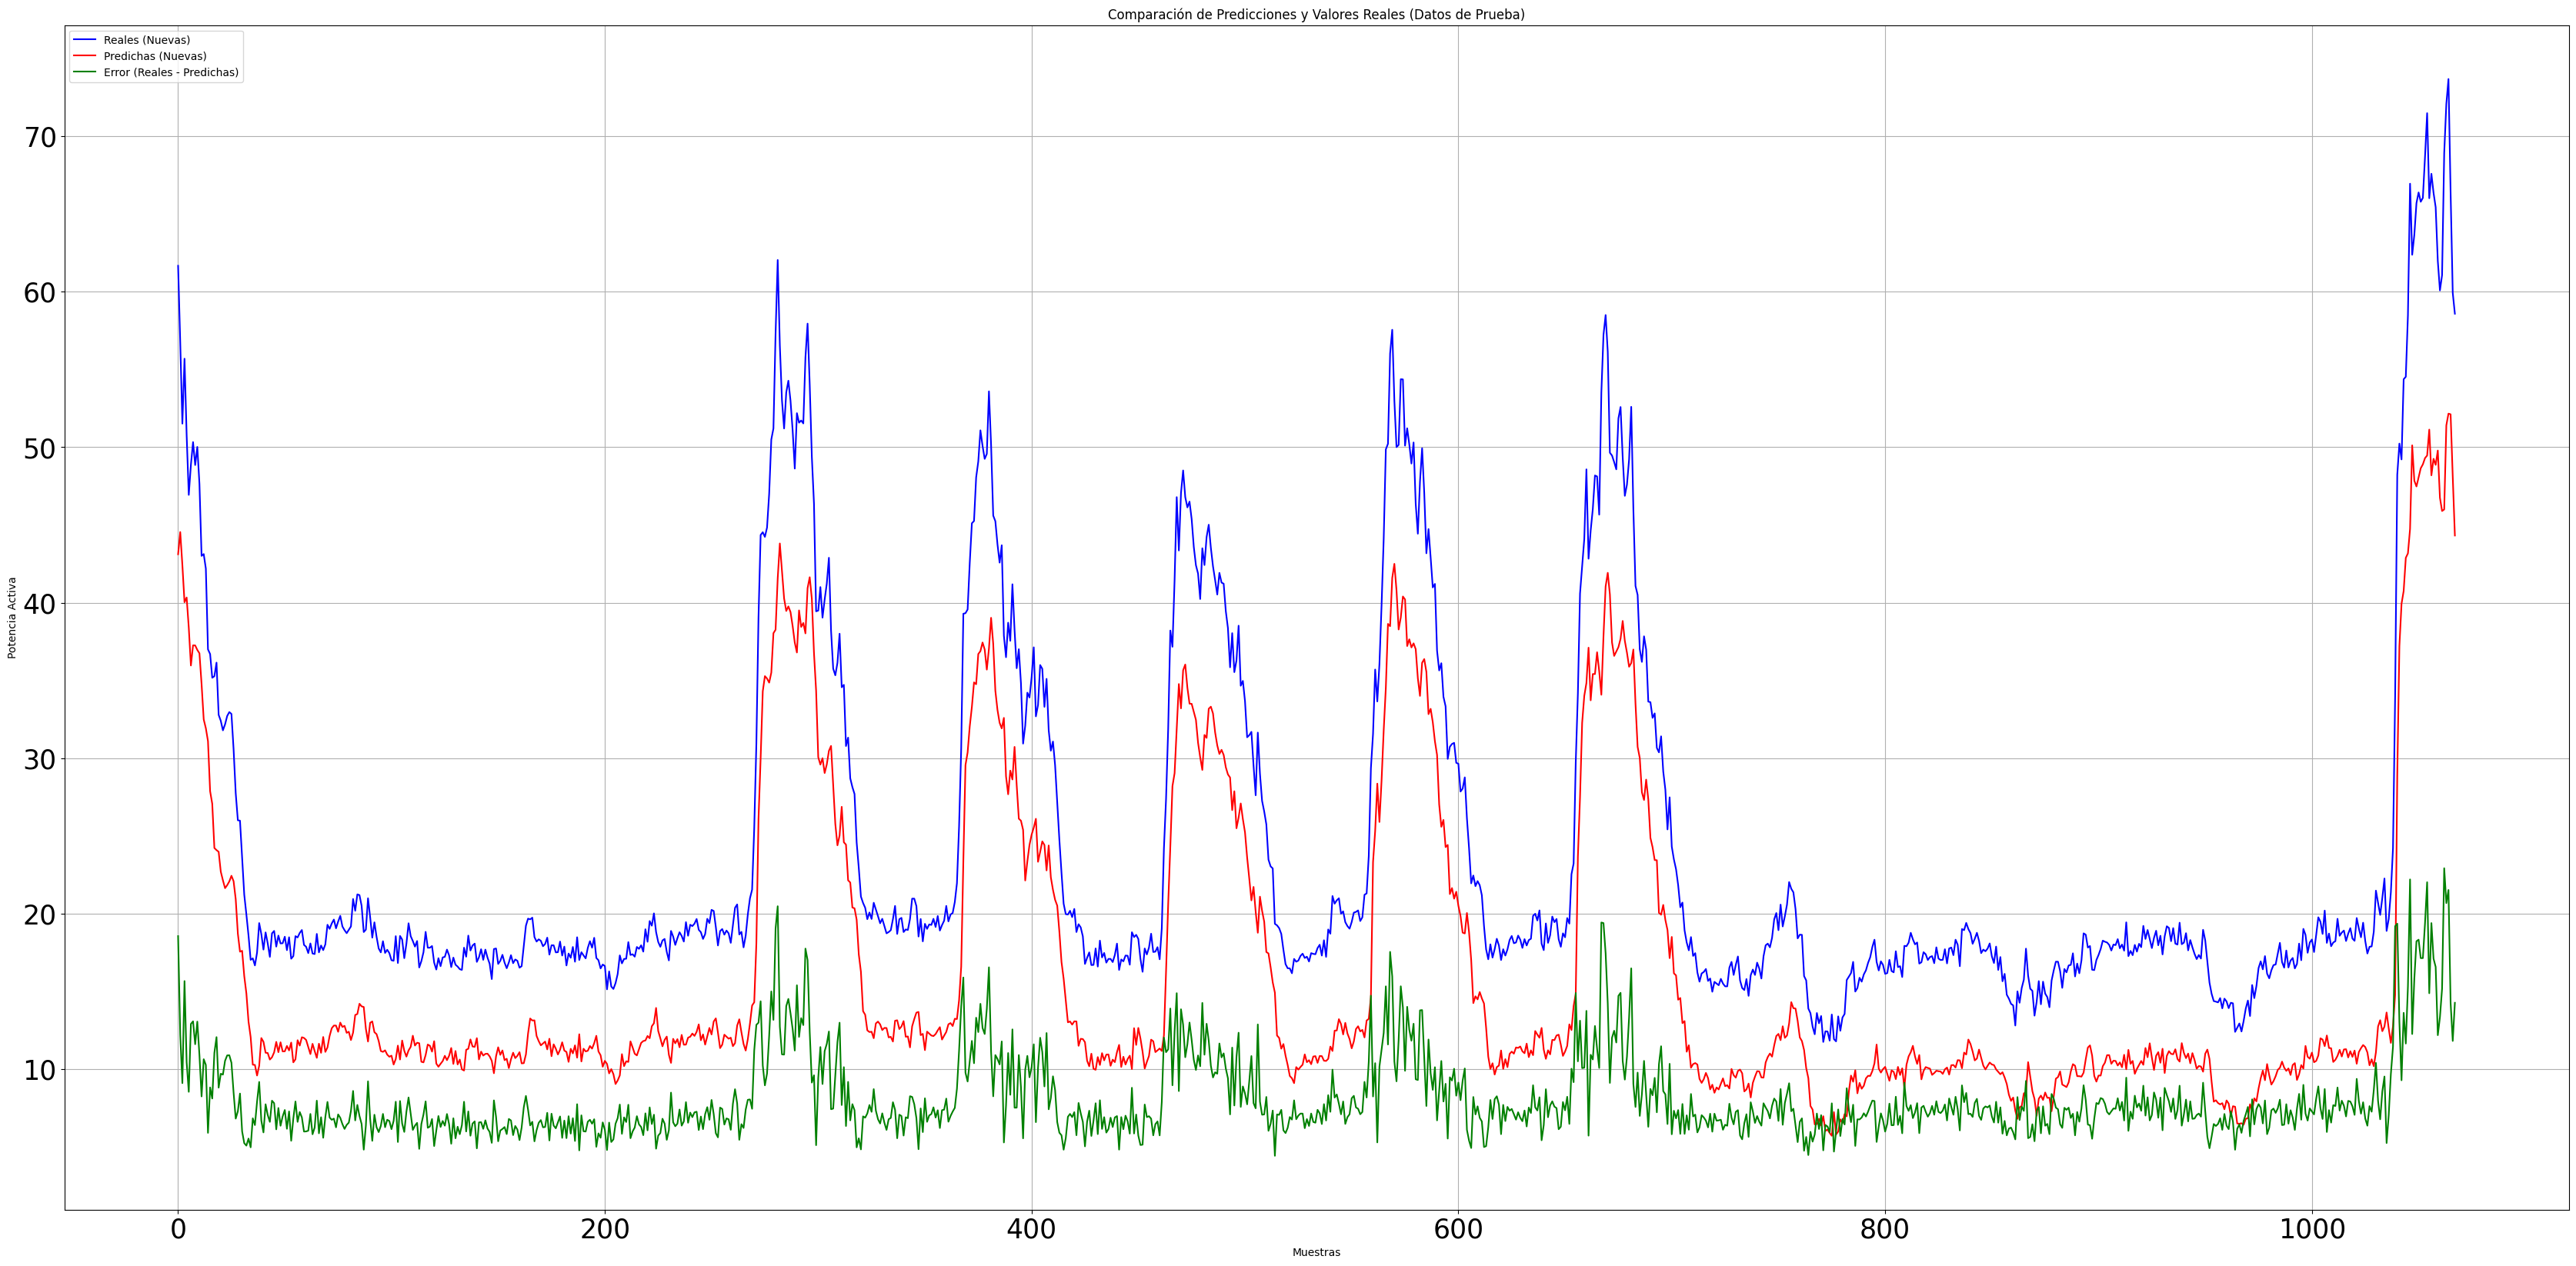

In [44]:
# Plot de datos de prueba 117207 121351 datos nuevos aprox 4000 ultimos
plt.figure(figsize=(42, 20))
error = ynuevo[3045:4145] - y_test_prednuevo[3045:4145]

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ynuevo[3045:4145], label='Reales (Nuevas)', linestyle='-', color='blue')
plt.plot(y_test_prednuevo[3045:4145], label='Predichas (Nuevas)', linestyle='-', color='red')
plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()


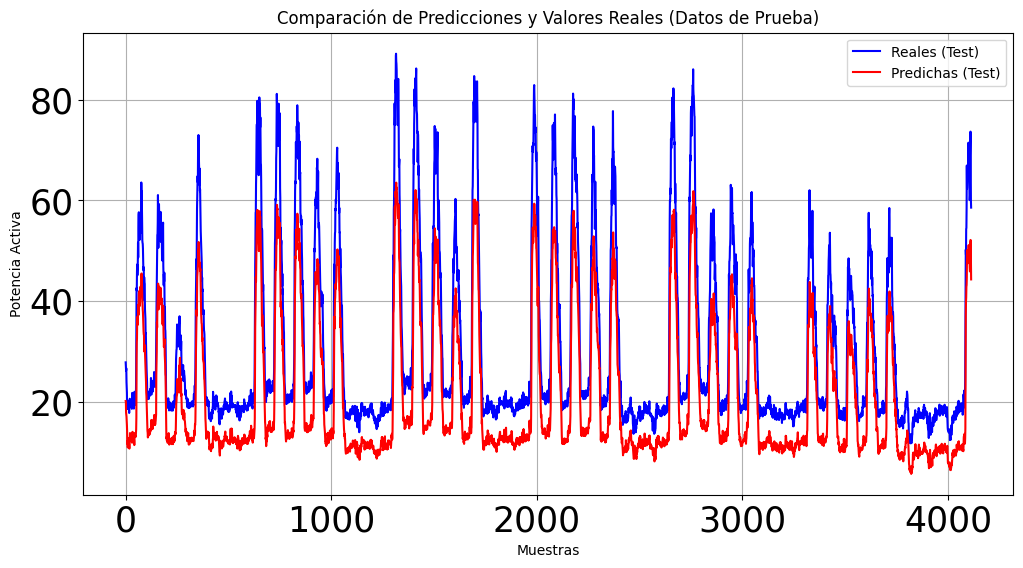

In [45]:
# Plot de datos de prueba
plt.figure(figsize=(12, 6))
error = ynuevo - y_test_prednuevo

# Ploteamos los primeros 100 datos reales y predichos como líneas
plt.plot(ynuevo, label='Reales (Test)', linestyle='-', color='blue')
plt.plot(y_test_prednuevo, label='Predichas (Test)', linestyle='-', color='red')
#plt.plot(error, label='Error (Reales - Predichas)', linestyle='-', color='green')

# Añadimos título y etiquetas
plt.title('Comparación de Predicciones y Valores Reales (Datos de Prueba)')
plt.xlabel('Muestras')
plt.ylabel('Potencia Activa')

# Añadimos la leyenda y la cuadrícula
plt.legend()
plt.grid(True)

# Mostramos el gráfico
plt.show()

In [46]:
min_error = np.min(error)
max_error = np.max(error)


# Encontrar los índices de los valores que tienen un valor absoluto mayor que 1
indices = np.where(np.abs(error) > 1)
# Contar cuántos valores cumplen la condición
cont = len(indices[0])

with open("resultados_nuevos.txt", "w") as file:
    file.write(f"Valor minimo del error: {min_error}\n")
    file.write(f"Valor maximo del error: {max_error}\n")
    file.write(f"Cantidad de valores con modulo mayor que el elegido: {cont}\n")

    file.write("Posiciones y valores:\n")
    for i in range(cont):
        row = indices[0][i]
        col = indices[1][i]
        file.write(f"indice: ({row}, {col}), Valor: {error[row, col]}\n")

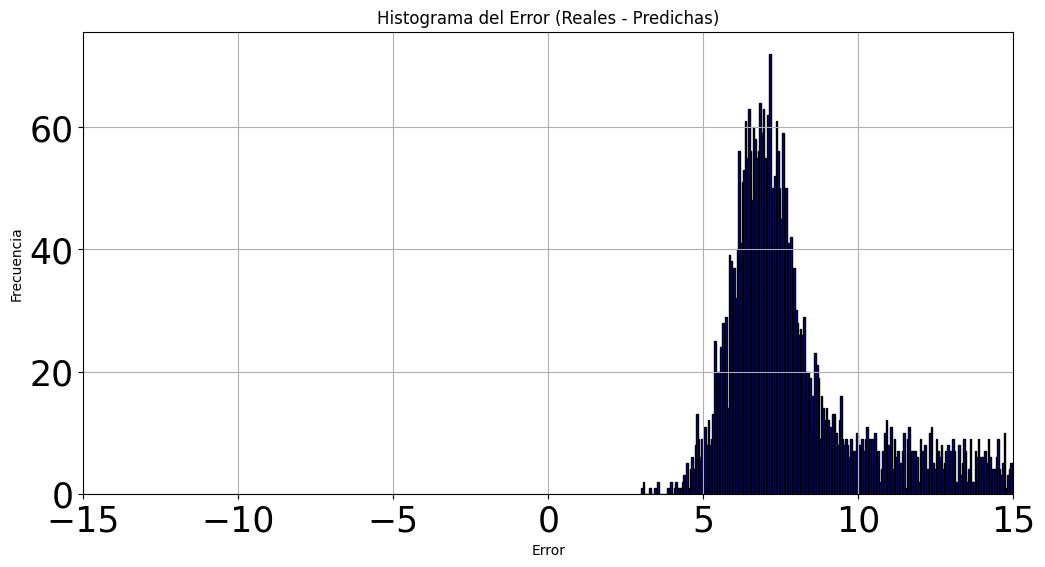

Desviación estándar del error: 4.38
med del error: 9.29


In [47]:
# Creamos un histograma del error
plt.figure(figsize=(12, 6))
plt.xlim(-15, 15)

plt.hist(error, bins=500, edgecolor='black', color='blue')

# Añadimos título y etiquetas
plt.title('Histograma del Error (Reales - Predichas)')
plt.xlabel('Error')
plt.ylabel('Frecuencia')

# Mostramos el gráfico
plt.grid(True)
plt.show()

std_deviation = np.std(error)
med = np.mean(error)
print(f"Desviación estándar del error: {std_deviation:.2f}")
print(f"med del error: {med:.2f}")